In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['schema_name'] = "anix_nnfabrik_bias_transfer_adv_noise"
# dj.config['schema_name'] = "anix_nnfabrik_bias_transfer_test"

import matplotlib.pyplot as plt
import numpy as np
from bias_transfer.dataset import dataset_loader
from bias_transfer.config import *
from bias_transfer.trainer import trainer
from bias_transfer.models import resnet_builder
from bias_transfer.analysis import *
from bias_transfer.main import *


from bias_transfer.tables.base import *
from bias_transfer.tables.transfer import *
import nnfabrik as nnf
# nnf.config['repos'] = ['/notebooks/nnfabrik']
from nnfabrik.main import *
schema

ModuleNotFoundError: No module named 'bias_transfer.dataset'

In [200]:
schema.jobs

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__trained_model,fc2f3bbf62047c54b44cc2273ddd60c2,reserved,=BLOB=,,=BLOB=,anix@cantor.mvl6.uni-tuebingen.de,552c85b47aaa,1,9823,2020-02-07 01:58:19
__trained_model,fc6629c12d273f4c122eeb87a99d4760,reserved,=BLOB=,,=BLOB=,anix@kowalewskaja.mvl6.uni-tuebingen.de,39ff107f1151,1,10001,2020-02-07 08:32:50
__trained_model,ff2b7a15f189c091b64ccc20b8fc5e9f,reserved,=BLOB=,,=BLOB=,anix@pythagoras.mvl6.uni-tuebingen.de,805dc322a070,1,9718,2020-02-06 12:56:01
__trained_transfer_model,47f916f9a24d6f7dd87c24644071f462,reserved,=BLOB=,,=BLOB=,anix@pythagoras.mvl6.uni-tuebingen.de,805dc322a070,1,9719,2020-02-07 10:23:53
__trained_transfer_model,86b9d179e027316c1fed9d5a657bd365,reserved,=BLOB=,,=BLOB=,anix@kowalewskaja.mvl6.uni-tuebingen.de,10d5d8a5220a,1,10002,2020-02-07 13:23:17
__trained_transfer_model,8859e542e8cfd21b3b21dbb812362c88,reserved,=BLOB=,,=BLOB=,anix@russell.mvl6.uni-tuebingen.de,6e1d183f9faa,1,9721,2020-02-07 11:52:24
__trained_transfer_model,eb040770de7f2b1101b8128f4364c8f1,reserved,=BLOB=,,=BLOB=,anix@russell.mvl6.uni-tuebingen.de,d568e3079883,1,9824,2020-02-07 10:36:58
__trained_transfer_model,fd489b09b65177d779aae449d79fb4f3,reserved,=BLOB=,,=BLOB=,anix@kowalewskaja.mvl6.uni-tuebingen.de,e80a4c24daf7,1,8355,2020-02-05 08:01:59


In [169]:
# noise="noise_snr_1.0_0.9.None_0.1"
# noise="noise_snr_1.0_1.0"
# noise="noise_snr_1.0_0.5.None_0.5"
# noise="noise_std_0.5_0.5.None_0.5"
# noise="noise_std_0.08_0.1.0.12_0.1.0.18_0.1.0.26_0.1.0.38_0.1.None_0.5"
noise="noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2"

In [170]:
t1 = (ConfigToTrain() & [{"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}".format(noise=noise)},
                        {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_8".format(noise=noise)},
                        {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_13".format(noise=noise)},
                  {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8"} ,
                  {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8"} ,
                  {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13"} ,
                       ]).proj(c_comment="comment") * TrainedModel()

In [171]:
t2 = (ConfigToTrainAndTransfer() & [{"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)},
                                    {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)},
                                    {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel()

In [172]:
t3 = (ConfigToTrainAndTransfer() & [{"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)},
                                    {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)},
                                    {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel()

In [173]:
t4 = (ConfigToTrainAndTransfer2() & [
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)}, 
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)}, 
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)}, 
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer"}, 
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer"}, 
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer"}, 
                   ]).proj(c_comment="comment") * TrainedTransferModel2()


In [174]:
t5 = (ConfigToTrainAndTransfer() & [
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_8.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_13.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel()


In [199]:
(ConfigToTrainAndTransfer() & [
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_8.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_13.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel2()

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,model_fn name of the model function,model_hash hash of the model configuration,seed Random seed that is passed to the model- and dataset-builder,transfer_1_model_fn name of the model function,transfer_1_model_hash hash of the model configuration,transfer_1_dataset_fn name of the dataset loader function,transfer_1_dataset_hash hash of the configuration object,transfer_1_trainer_fn name of the Trainer loader function,transfer_1_trainer_hash hash of the configuration object,transfer_1_seed Random seed that is passed to the model- and dataset-builder,transfer_2_model_fn name of the model function,transfer_2_model_hash hash of the model configuration,transfer_2_dataset_fn name of the dataset loader function,transfer_2_dataset_hash hash of the configuration object,transfer_2_trainer_fn name of the Trainer loader function,transfer_2_trainer_hash hash of the configuration object,transfer_2_seed Random seed that is passed to the model- and dataset-builder,c_comment short description,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
bias_transfer.trainer.trainer,24a699ad516a8bf14b43545a549d2e00,bias_transfer.dataset.dataset_loader,8101e4af46ed0ff1acb4c5701231eb9e,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,8,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,8101e4af46ed0ff1acb4c5701231eb9e,bias_transfer.trainer.trainer,2aee702a4a3f8e3283c513cd05db6dd7,8,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,8101e4af46ed0ff1acb4c5701231eb9e,bias_transfer.trainer.trainer,765aa70e134dced43ec256c1279d0f9a,8,"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8 optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.seed_8.transfer_True.freeze_('readout',).transfer","optimizer_Adam.lr_0.0003.lr_decay_0.8 resnet50.100 CIFAR100.128 optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.freeze_('readout',) resnet50.100 CIFAR100.128 optimizer_Adam.lr_0.0003.lr_decay_0.8.freeze_('core',).reset_linear_True resnet50.100 CIFAR100.128",63.43,=BLOB=,Arne Nix,2020-02-06 09:51:04
bias_transfer.trainer.trainer,24a699ad516a8bf14b43545a549d2e00,bias_transfer.dataset.dataset_loader,8101e4af46ed0ff1acb4c5701231eb9e,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,8,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,8101e4af46ed0ff1acb4c5701231eb9e,bias_transfer.trainer.trainer,2aee702a4a3f8e3283c513cd05db6dd7,8,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,8101e4af46ed0ff1acb4c5701231eb9e,bias_transfer.trainer.trainer,c63f8a217f04eac40f22cf68cc90df3e,8,"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8 optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.seed_8.transfer_True.freeze_('readout',).transfer","optimizer_Adam.lr_0.0003.lr_decay_0.8 resnet50.100 CIFAR100.128 optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.freeze_('readout',) resnet50.100 CIFAR100.128 optimizer_Adam.lr_0.0003.lr_decay_0.8.freeze_('core',) resnet50.100 CIFAR100.128",63.39,=BLOB=,Arne Nix,2020-02-06 13:17:47
bias_transfer.trainer.trainer,24a699ad516a8bf14b43545a549d2e00,bias_transfer.dataset.dataset_loader,8101e4af46ed0ff1acb4c5701231eb9e,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,13,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loa

In [176]:
t7 = (ConfigToTrain() & [
                     {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_".format(noise=noise)},
                     {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_batch_8".format(noise=noise)},
                     {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_batch_64".format(noise=noise)},
                     {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_epoch_1".format(noise=noise)},
                     {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_epoch_4".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedModel()

In [188]:
t8 = (ConfigToTrain() & [
                     {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_".format(noise=noise)},
                     {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_batch_8".format(noise=noise)},
                     {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_batch_64".format(noise=noise)},
                     {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_epoch_1".format(noise=noise)},
                     {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_epoch_4".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel()

In [189]:
t9 = (ConfigToTrainAndTransfer() & [
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_('core',).reset_linear_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_batch_64\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_('core',).reset_linear_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_batch_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_('core',).reset_linear_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_epoch_4\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_('core',).reset_linear_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_epoch_1\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_('core',).reset_linear_True.transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel()

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,model_fn name of the model function,model_hash hash of the model configuration,seed Random seed that is passed to the model- and dataset-builder,transfer_1_model_fn name of the model function,transfer_1_model_hash hash of the model configuration,transfer_1_dataset_fn name of the dataset loader function,transfer_1_dataset_hash hash of the configuration object,transfer_1_trainer_fn name of the Trainer loader function,transfer_1_trainer_hash hash of the configuration object,transfer_1_seed Random seed that is passed to the model- and dataset-builder,c_comment short description,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion


In [190]:
t10 = (ConfigToTrainAndTransfer() & [
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_('core',).reset_linear_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_batch_64\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_('core',).reset_linear_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_batch_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_('core',).reset_linear_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_epoch_4\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_('core',).reset_linear_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.freeze_('readout',).reset_linear_True.reset_linear_frequency_epoch_1\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_('core',).reset_linear_True.transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel2()

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,model_fn name of the model function,model_hash hash of the model configuration,seed Random seed that is passed to the model- and dataset-builder,transfer_1_model_fn name of the model function,transfer_1_model_hash hash of the model configuration,transfer_1_dataset_fn name of the dataset loader function,transfer_1_dataset_hash hash of the configuration object,transfer_1_trainer_fn name of the Trainer loader function,transfer_1_trainer_hash hash of the configuration object,transfer_1_seed Random seed that is passed to the model- and dataset-builder,transfer_2_model_fn name of the model function,transfer_2_model_hash hash of the model configuration,transfer_2_dataset_fn name of the dataset loader function,transfer_2_dataset_hash hash of the configuration object,transfer_2_trainer_fn name of the Trainer loader function,transfer_2_trainer_hash hash of the configuration object,transfer_2_seed Random seed that is passed to the model- and dataset-builder,c_comment short description,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion


In [191]:
t11 = (ConfigToTrainAndTransfer() & [
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.transfer_True.freeze_('readout',).reset_linear_True.reset_linear_frequency_.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.transfer_True.freeze_('readout',).reset_linear_True.reset_linear_frequency_batch_8.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.transfer_True.freeze_('readout',).reset_linear_True.reset_linear_frequency_batch_64.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.transfer_True.freeze_('readout',).reset_linear_True.reset_linear_frequency_epoch_1.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.transfer_True.freeze_('readout',).reset_linear_True.reset_linear_frequency_epoch_4.transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel()

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,model_fn name of the model function,model_hash hash of the model configuration,seed Random seed that is passed to the model- and dataset-builder,transfer_1_model_fn name of the model function,transfer_1_model_hash hash of the model configuration,transfer_1_dataset_fn name of the dataset loader function,transfer_1_dataset_hash hash of the configuration object,transfer_1_trainer_fn name of the Trainer loader function,transfer_1_trainer_hash hash of the configuration object,transfer_1_seed Random seed that is passed to the model- and dataset-builder,c_comment short description,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion


In [193]:
t12 = (ConfigToTrain() & [
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.batch_size_64.freeze_('readout',).clean_noisy_comp_regularization_1.0".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.batch_size_64.freeze_('readout',).clean_noisy_comp_regularization_10.0".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.batch_size_64.freeze_('readout',).clean_noisy_comp_regularization_100.0".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedModel()

In [194]:
(ConfigToTrainAndTransfer() & [{"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.batch_size_64\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.batch_size_64.transfer_True.freeze_('readout',).clean_noisy_comp_regularization_1.0.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.batch_size_64\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.batch_size_64.transfer_True.freeze_('readout',).clean_noisy_comp_regularization_10.0.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.batch_size_64\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.batch_size_64.transfer_True.freeze_('readout',).clean_noisy_comp_regularization_100.0.transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel()

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,model_fn name of the model function,model_hash hash of the model configuration,seed Random seed that is passed to the model- and dataset-builder,transfer_1_model_fn name of the model function,transfer_1_model_hash hash of the model configuration,transfer_1_dataset_fn name of the dataset loader function,transfer_1_dataset_hash hash of the configuration object,transfer_1_trainer_fn name of the Trainer loader function,transfer_1_trainer_hash hash of the configuration object,transfer_1_seed Random seed that is passed to the model- and dataset-builder,c_comment short description,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion


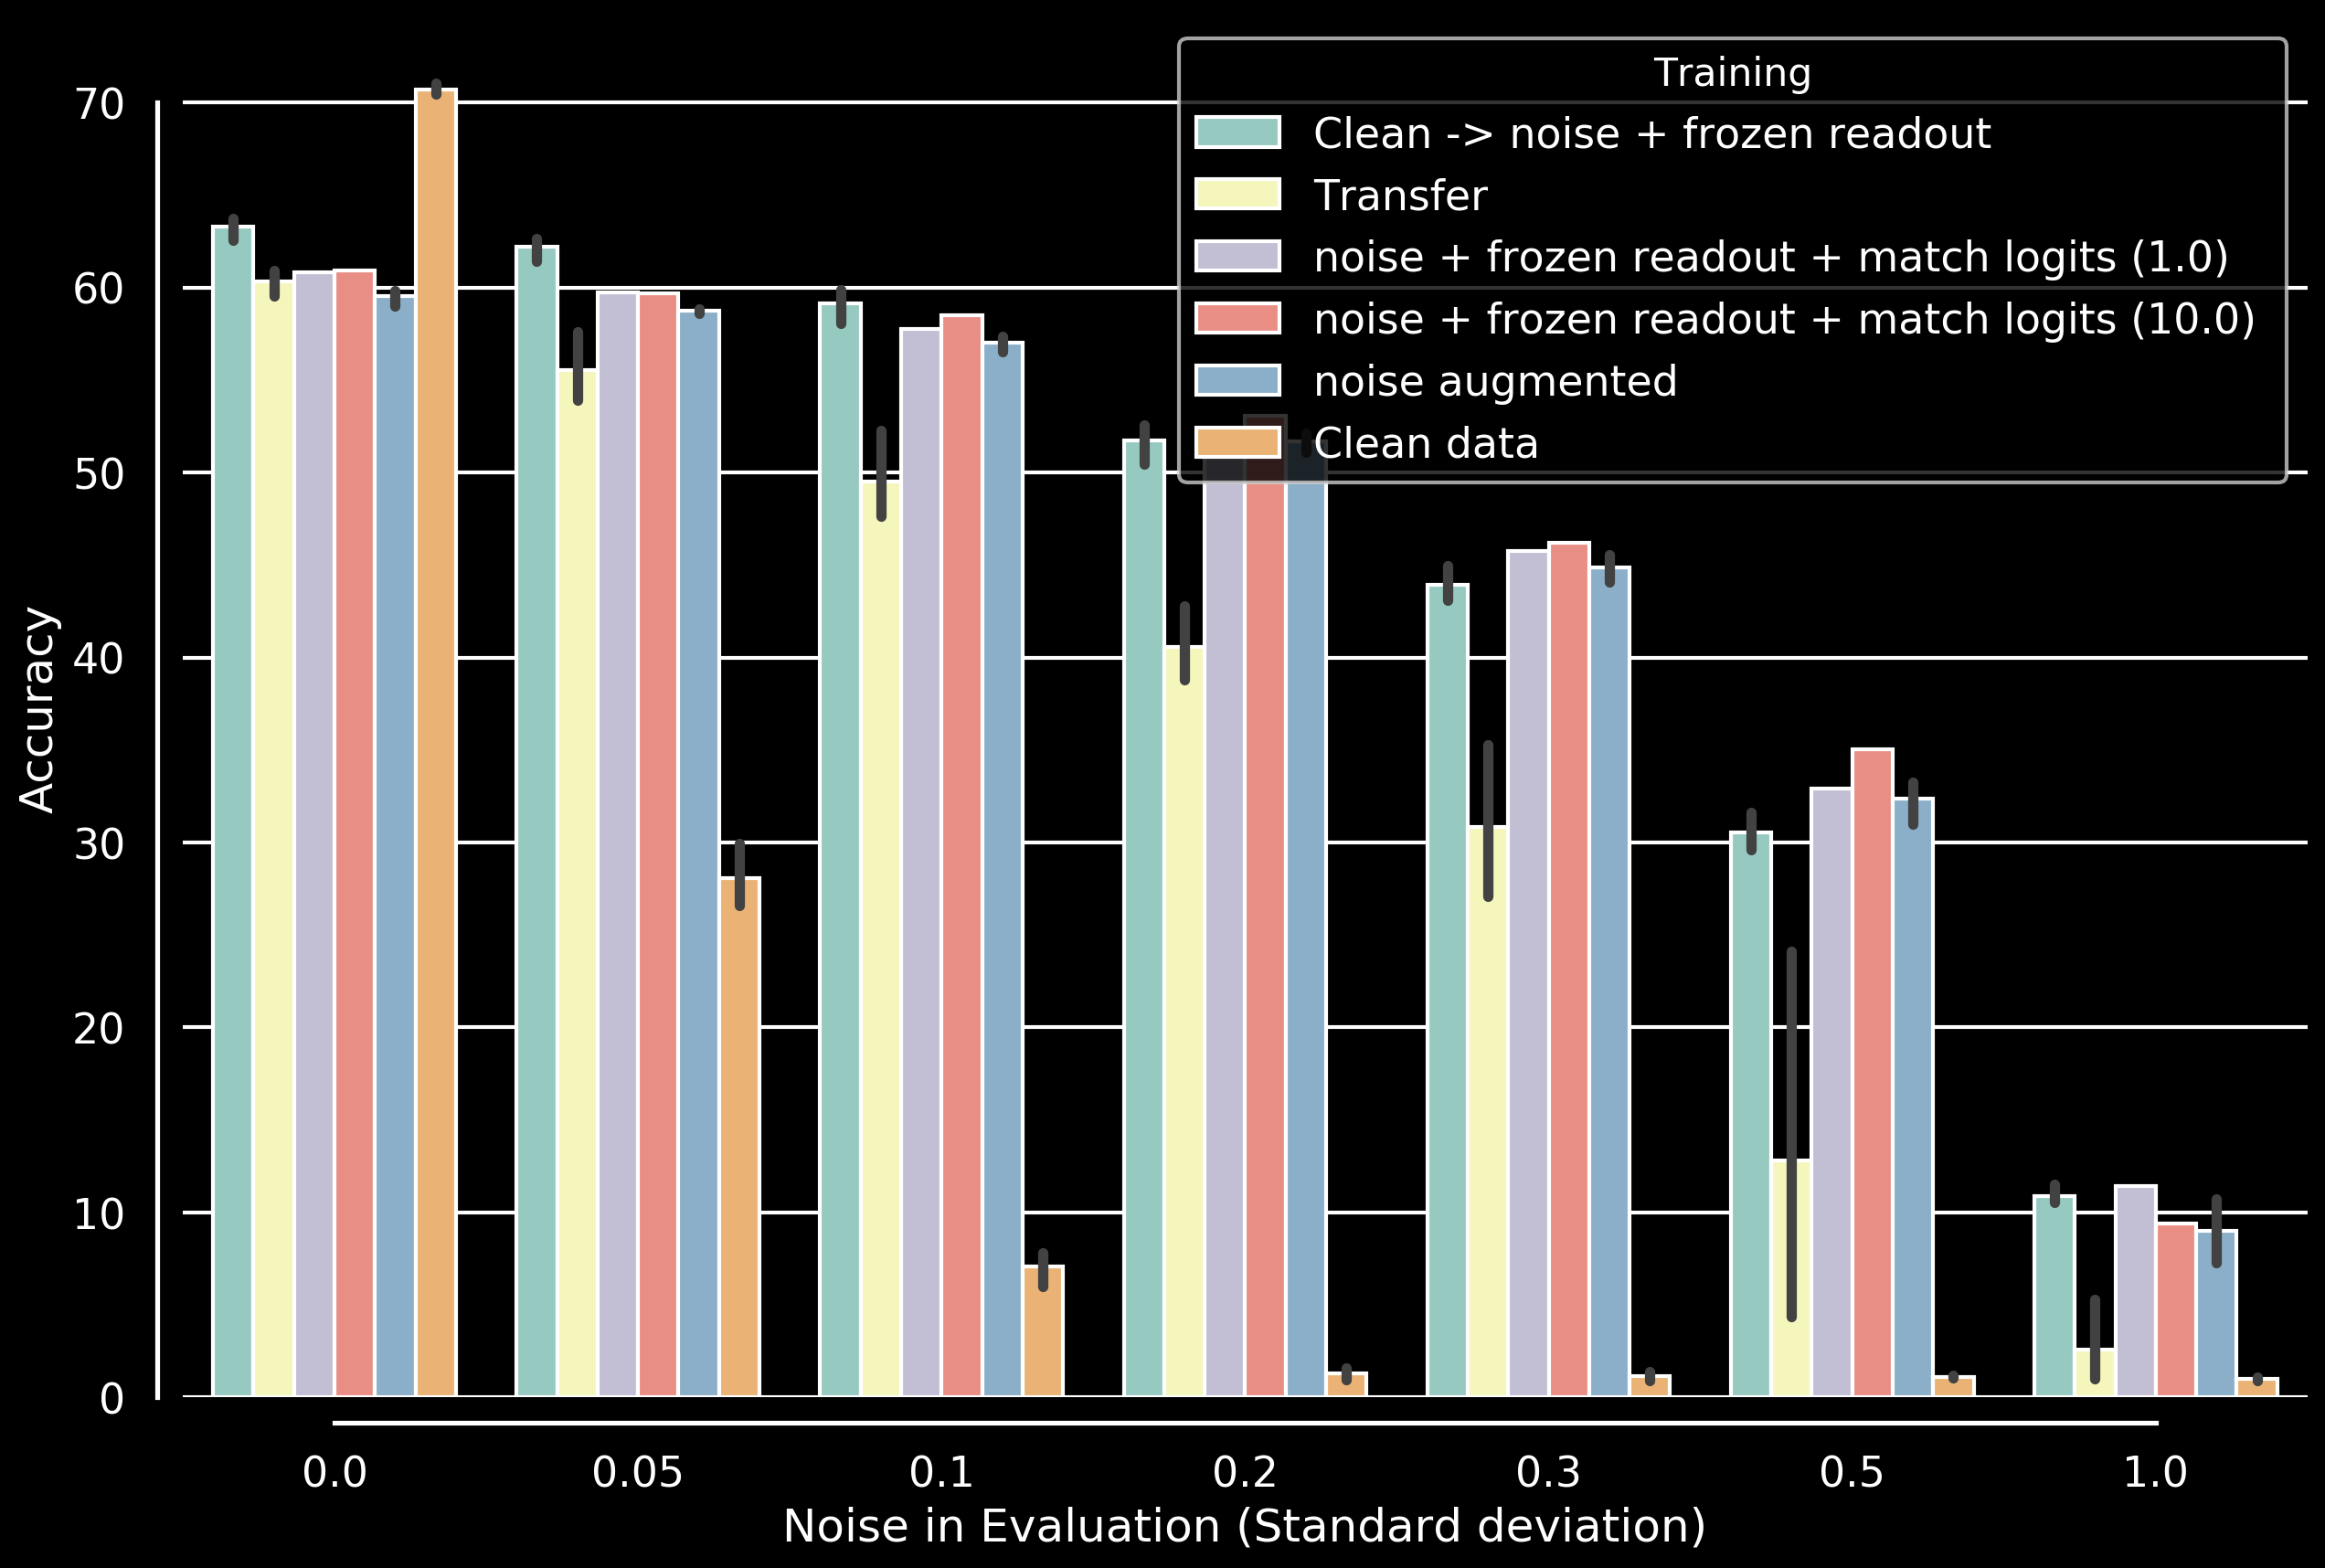

In [196]:
a = Analyzer(tables=(t1,t2,t5,t12), 
           comment_map={
                        "optimizer_Adam.lr_0.0003.lr_decay_0.8\nresnet50.100\nCIFAR100.128\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.None_0.5\nresnet50.100\nCIFAR100.128\noptimizer_Adam.lr_0.0003.lr_decay_0.8.freeze_True\nresnet50.100\nCIFAR100.128".format(noise=noise): "Transfer long",
                        "adv_classification": "Transfer Class",
                        "adv_regression": "Transfer Regress",
                        "optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.resnet50.100.CIFAR100.128".format(noise=noise): "noise augmented",
                        "optimizer_Adam.lr_0.0003.lr_decay_0.8\nresnet50.100\nCIFAR100.128\noptimizer_Adam.lr_0.0003.lr_decay_0.8\nresnet50.100\nCIFAR100.128":"Clean long",
                        "optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}\nresnet50.100\nCIFAR100.128\noptimizer_Adam.lr_0.0003.lr_decay_0.8.freeze_True\nresnet50.100\nCIFAR100.128".format(noise=noise) : "Transfer",
                       "optimizer_Adam.lr_0.0003.lr_decay_0.8.resnet50.100.CIFAR100.128": "Clean data", 
                       "reset_linear_frequency_batch_64": "noise + frozen random readout (reset batch 64)", 
                       "reset_linear_frequency_batch_8": "noise + frozen random readout (reset batch 8)", 
                       "reset_linear_frequency_epoch_1": "noise + frozen random readout (reset epoch 1) ", 
                       "reset_linear_frequency_epoch_4": "noise + frozen random readout (reset epoch 4) ", 
                       "reset_linear_frequency_": "noise + frozen random readout ", 
                       "clean_noisy_comp_regularization_1.0": "noise + frozen readout + match logits (1.0) ", 
                       "clean_noisy_comp_regularization_10.0": "noise + frozen readout + match logits (10.0) ", 
                       "clean_noisy_comp_regularization_100.0": "noise + frozen readout + match logits (100.0) ", 
                       "freeze_('core',)": "Clean -> noise + frozen readout -> Transfer ", 
                       "freeze_('readout',)": "Clean -> noise + frozen readout ", 
                       },
            )
fig, ax = a.plot(to_plot="dev_noise_acc", 
       noise_measure="std",
       kind=None, 
       plot_method=sns.barplot,
        save="transfer_noise_adv_with_pretrain_"+noise+".png"
       )
# a.plot( #to_plot="dev_noise_acc", 
#         to_plot="training_progress", 
#        noise_measure="std",
#        kind=None, 
# #        plot_method=sns.barplot,
#        plot_method=sns.lineplot,
# #        save="inductive_bias_"+noise+".png"
#        )                             

In [99]:
ConfigToTrain() & "comment LIKE '%clean_noisy_comp_regularization%'"

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,model_fn name of the model function,model_hash hash of the model configuration,seed Random seed that is passed to the model- and dataset-builder,config configuration object,config_fabrikant Name of the contributor that added this entry,comment short description,ts UTZ timestamp at time of insertion
bias_transfer.trainer.trainer,89c1d76429b3d4cba20622e45b968db3,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,42,=BLOB=,Arne Nix,"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.batch_size_64.freeze_('readout',).clean_noisy_comp_regularization_1.0",2020-02-06 18:07:03
bias_transfer.trainer.trainer,da8135524cc2aa3c8b118d25bcdb19ab,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,42,=BLOB=,Arne Nix,"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.batch_size_64.freeze_('readout',).clean_noisy_comp_regularization_100.0",2020-02-06 18:07:05
bias_transfer.trainer.trainer,e9b98f2ceaf08bf4cc1047bdae2b3239,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,42,=BLOB=,Arne Nix,"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.batch_size_64.freeze_('readout',).clean_noisy_comp_regularization_10.0",2020-02-06 18:07:04


In [100]:
ConfigToTrainAndTransfer() & "comment LIKE '%clean_noisy_comp_regularization%'"

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,model_fn name of the model function,model_hash hash of the model configuration,seed Random seed that is passed to the model- and dataset-builder,transfer_1_model_fn name of the model function,transfer_1_model_hash hash of the model configuration,transfer_1_dataset_fn name of the dataset loader function,transfer_1_dataset_hash hash of the configuration object,transfer_1_trainer_fn name of the Trainer loader function,transfer_1_trainer_hash hash of the configuration object,transfer_1_seed Random seed that is passed to the model- and dataset-builder,config configuration object,transfer_1_config configuration object,config_fabrikant Name of the contributor that added this entry,comment short description,ts UTZ timestamp at time of insertion
bias_transfer.trainer.trainer,89c1d76429b3d4cba20622e45b968db3,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,42,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.trainer.trainer,3abb4040fbe263918e7118dd742b36ef,42,=BLOB=,=BLOB=,Arne Nix,"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.batch_size_64.freeze_('readout',).clean_noisy_comp_regularization_1.0 optimizer_Adam.lr_0.0003.lr_decay_0.8.batch_size_64.transfer_True.freeze_('core',).reset_linear_True.transfer",2020-02-06 18:07:03
bias_transfer.trainer.trainer,b481278cd0f901ab7f63a59221ee9c0d,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,42,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.trainer.trainer,89c1d76429b3d4cba20622e45b968db3,42,=BLOB=,=BLOB=,Arne Nix,"optimizer_Adam.lr_0.0003.lr_decay_0.8.batch_size_64 optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.batch_size_64.transfer_True.freeze_('readout',).clean_noisy_comp_regularization_1.0.transfer",2020-02-06 18:07:04
bias_transfer.trainer.trainer,b481278cd0f901ab7f63a59221ee9c0d,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,42,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.trainer.trainer,da8135524cc2aa3c8b118d25bcdb19ab,42,=BLOB=,=BLOB=,Arne Nix,"optimizer_Adam.lr_0.0003.lr_decay_0.8.batch_size_64 optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.batch_size_64.transfer_True.freeze_('readout',).clean_noisy_comp_regularization_100.0.transfer",2020-02-06 18:07:06
bias_transfer.trainer.trainer,b481278cd0f901ab7f63a59221ee9c0d,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,42,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.trainer.trainer,e9b98f2ceaf08bf4cc1047bdae2b3239,42,=BLOB=,=BLOB=,Arne Nix,"optimizer_Adam.lr_0.0003.lr_decay_0.8.batch_size_64 optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.batch_size_64.transfer_True.freeze_('readout',).clean_noisy_comp_regularization_10.0.transfer",2020-02-06 18:07:05
bias_transfer.trainer.trainer,da8135524cc2aa3c8b118d25bcdb19ab,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f

In [101]:
ConfigToTrainAndTransfer2() & "comment LIKE '%clean_noisy_comp_regularization%'"

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,model_fn name of the model function,model_hash hash of the model configuration,seed Random seed that is passed to the model- and dataset-builder,transfer_1_model_fn name of the model function,transfer_1_model_hash hash of the model configuration,transfer_1_dataset_fn name of the dataset loader function,transfer_1_dataset_hash hash of the configuration object,transfer_1_trainer_fn name of the Trainer loader function,transfer_1_trainer_hash hash of the configuration object,transfer_1_seed Random seed that is passed to the model- and dataset-builder,transfer_2_model_fn name of the model function,transfer_2_model_hash hash of the model configuration,transfer_2_dataset_fn name of the dataset loader function,transfer_2_dataset_hash hash of the configuration object,transfer_2_trainer_fn name of the Trainer loader function,transfer_2_trainer_hash hash of the configuration object,transfer_2_seed Random seed that is passed to the model- and dataset-builder,config configuration object,transfer_1_config configuration object,transfer_2_config configuration object,config_fabrikant Name of the contributor that added this entry,comment short description,ts UTZ timestamp at time of insertion
bias_transfer.trainer.trainer,b481278cd0f901ab7f63a59221ee9c0d,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,42,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.trainer.trainer,89c1d76429b3d4cba20622e45b968db3,42,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.trainer.trainer,3abb4040fbe263918e7118dd742b36ef,42,=BLOB=,=BLOB=,=BLOB=,Arne Nix,"optimizer_Adam.lr_0.0003.lr_decay_0.8.batch_size_64 optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.batch_size_64.transfer_True.freeze_('readout',).clean_noisy_comp_regularization_1.0.transfer optimizer_Adam.lr_0.0003.lr_decay_0.8.batch_size_64.transfer_True.freeze_('core',).reset_linear_True.transfer",2020-02-06 18:07:04
bias_transfer.trainer.trainer,b481278cd0f901ab7f63a59221ee9c0d,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,42,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.trainer.trainer,da8135524cc2aa3c8b118d25bcdb19ab,42,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.trainer.trainer,3abb4040fbe263918e7118dd742b36ef,42,=BLOB=,=BLOB=,=BLOB=,Arne Nix,"optimizer_Adam.lr_0.0003.lr_decay_0.8.batch_size_64 optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2.batch_size_64.transfer_True.freeze_('readout',).clean_noisy_comp_regularization_100.0.transfer optimizer_Adam.lr_0.0003.lr_decay_0.8.batch_size_64.transfer_True.freeze_('core',).reset_linear_True.transfer",2020-02-06 18:07:06
bias_transfer.trainer.trainer,b481278cd0f901ab7f63a59221ee9c0d,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,42,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_transfer.trainer.trainer,e9b98f2ceaf08bf4cc1047bdae2b3239,42,bias_transfer.models.resnet_builder,10b6e661a5586661bf63b2081d1f83d8,bias_transfer.dataset.dataset_loader,0933de1655522b3c0c9c7cf41f3bf3e5,bias_tran